In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid

In [2]:
# Model Hyperparameters

dataset_path = '~/datasets'

cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")


batch_size = 128
img_size = (32, 32) # (width, height)

input_dim = 3
hidden_dim = 128
n_embeddings= 768
output_dim = 3

lr = 2e-4

epochs = 50

print_step = 50

###    Step 1. Load (or download) Dataset

In [3]:
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


mnist_transform = transforms.Compose([
        transforms.ToTensor(),
])

kwargs = {'num_workers': 1, 'pin_memory': True} 

train_dataset = CIFAR10(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = CIFAR10(dataset_path, transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False,  **kwargs)

Files already downloaded and verified
Files already downloaded and verified


### Step 2. Define our model: Vector Quantized Variational AutoEncoder (VQ-VAE)

In [4]:
class Encoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, kernel_size=(4, 4, 3, 1), stride=2):
        super(Encoder, self).__init__()
        
        kernel_1, kernel_2, kernel_3, kernel_4 = kernel_size
        
        self.strided_conv_1 = nn.Conv2d(input_dim, hidden_dim, kernel_1, stride, padding=1)
        self.strided_conv_2 = nn.Conv2d(hidden_dim, hidden_dim, kernel_2, stride, padding=1)
        
        self.residual_conv_1 = nn.Conv2d(hidden_dim, hidden_dim, kernel_3, padding=1)
        self.residual_conv_2 = nn.Conv2d(hidden_dim, output_dim, kernel_4, padding=0)
        
    def forward(self, x):
        
        x = self.strided_conv_1(x)
        x = self.strided_conv_2(x)
        
        x = F.relu(x)
        y = self.residual_conv_1(x)
        y = y+x
        
        x = F.relu(y)
        y = self.residual_conv_2(x)
        y = y+x
        
        return y

In [5]:
class VQEmbeddingEMA(nn.Module):
    def __init__(self, n_embeddings, embedding_dim, commitment_cost=0.25, decay=0.999, epsilon=1e-5):
        super(VQEmbeddingEMA, self).__init__()
        self.commitment_cost = commitment_cost
        self.decay = decay
        self.epsilon = epsilon
        
        init_bound = 1 / n_embeddings
        embedding = torch.Tensor(n_embeddings, embedding_dim)
        embedding.uniform_(-init_bound, init_bound)
        self.register_buffer("embedding", embedding)
        self.register_buffer("ema_count", torch.zeros(n_embeddings))
        self.register_buffer("ema_weight", self.embedding.clone())

    def encode(self, x):
        M, D = self.embedding.size()
        x_flat = x.detach().reshape(-1, D)

        distances = torch.addmm(torch.sum(self.embedding ** 2, dim=1) +
                    torch.sum(x_flat ** 2, dim=1, keepdim=True),
                                x_flat, self.embedding.t(),
                                alpha=-2.0, beta=1.0)

        indices = torch.argmin(distances.float(), dim=-1)
        quantized = F.embedding(indices, self.embedding)
        quantized = quantized.view_as(x)
        return quantized, indices.view(x.size(0), x.size(1))
    
    def retrieve_random_codebook(self, random_indices):
        quantized = F.embedding(random_indices, self.embedding)
        quantized = quantized.transpose(1, 3)
        
        return quantized

    def forward(self, x):
        M, D = self.embedding.size()
        x_flat = x.detach().reshape(-1, D)
        
        distances = torch.addmm(torch.sum(self.embedding ** 2, dim=1) +
                                torch.sum(x_flat ** 2, dim=1, keepdim=True),
                                x_flat, self.embedding.t(),
                                alpha=-2.0, beta=1.0)

        indices = torch.argmin(distances.float(), dim=-1)
        encodings = F.one_hot(indices, M).float()
        quantized = F.embedding(indices, self.embedding)
        quantized = quantized.view_as(x)
        
        if self.training:
            self.ema_count = self.decay * self.ema_count + (1 - self.decay) * torch.sum(encodings, dim=0)
            n = torch.sum(self.ema_count)
            self.ema_count = (self.ema_count + self.epsilon) / (n + M * self.epsilon) * n

            dw = torch.matmul(encodings.t(), x_flat)
            self.ema_weight = self.decay * self.ema_weight + (1 - self.decay) * dw
            self.embedding = self.ema_weight / self.ema_count.unsqueeze(-1)

        codebook_loss = F.mse_loss(x.detach(), quantized)
        e_latent_loss = F.mse_loss(x, quantized.detach())
        commitment_loss = self.commitment_cost * e_latent_loss

        quantized = x + (quantized - x).detach()

        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        return quantized, commitment_loss, codebook_loss, perplexity

In [6]:
class Decoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, kernel_sizes=(1, 3, 2, 2), stride=2):
        super(Decoder, self).__init__()
        
        kernel_1, kernel_2, kernel_3, kernel_4 = kernel_sizes
        
        self.residual_conv_1 = nn.Conv2d(input_dim, hidden_dim, kernel_1, padding=0)
        self.residual_conv_2 = nn.Conv2d(hidden_dim, hidden_dim, kernel_2, padding=1)
        
        self.strided_t_conv_1 = nn.ConvTranspose2d(hidden_dim, hidden_dim, kernel_3, stride, padding=0)
        self.strided_t_conv_2 = nn.ConvTranspose2d(hidden_dim, output_dim, kernel_4, stride, padding=0)
        
    def forward(self, x):
        
        y = self.residual_conv_1(x)
        y = y+x
        x = F.relu(y)
        
        y = self.residual_conv_2(x)
        y = y+x
        y = F.relu(y)
        
        y = self.strided_t_conv_1(y)
        y = self.strided_t_conv_2(y)
        
        return y

In [7]:
class Model(nn.Module):
    def __init__(self, Encoder, Codebook, Decoder):
        super(Model, self).__init__()
        self.encoder = Encoder
        self.codebook = Codebook
        self.decoder = Decoder
                
    def forward(self, x):
        z = self.encoder(x)
        z_quantized, commitment_loss, codebook_loss, perplexity = self.codebook(z)
        x_hat = self.decoder(z_quantized)
        
        return x_hat, commitment_loss, codebook_loss, perplexity
    
    

In [8]:
encoder = Encoder(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=hidden_dim)
codebook = VQEmbeddingEMA(n_embeddings=n_embeddings, embedding_dim=hidden_dim)
decoder = Decoder(input_dim=hidden_dim, hidden_dim=hidden_dim, output_dim=output_dim)

model = Model(Encoder=encoder, Codebook=codebook, Decoder=decoder).to(DEVICE)

### Step 3. Define Loss function (reprod. loss) and optimizer

In [9]:
from torch.optim import Adam

mse_loss = nn.MSELoss()

optimizer = Adam(model.parameters(), lr=lr)

### Step 4. Train Vector Quantized Variational AutoEncoder (VQ-VAE)

In [10]:
print("Start training VQ-VAE...")
model.train()

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, commitment_loss, codebook_loss, perplexity = model(x)
        recon_loss = mse_loss(x_hat, x)
        
        loss =  recon_loss + commitment_loss + codebook_loss
                
        loss.backward()
        optimizer.step()
        
        if batch_idx % print_step ==0: 
            print("epoch:", epoch + 1, "  step:", batch_idx + 1, "  recon_loss:", recon_loss.item(), "  perplexity: ", perplexity.item(), 
              "\n\t\tcommit_loss: ", commitment_loss.item(), "  codebook loss: ", codebook_loss.item(), "  total_loss: ", loss.item())
    
print("Finish!!")

Start training VQ-VAE...
epoch: 1   step: 1   recon_loss: 0.32385456562042236   perplexity:  49.421241760253906 
		commit_loss:  0.0065625375136733055   codebook loss:  0.026250150054693222   total_loss:  0.35666725039482117
epoch: 1   step: 51   recon_loss: 0.04821508377790451   perplexity:  29.88054847717285 
		commit_loss:  0.021651318296790123   codebook loss:  0.08660527318716049   total_loss:  0.15647166967391968
epoch: 1   step: 101   recon_loss: 0.040474675595760345   perplexity:  48.35503387451172 
		commit_loss:  0.0379059761762619   codebook loss:  0.1516239047050476   total_loss:  0.23000454902648926
epoch: 1   step: 151   recon_loss: 0.035965725779533386   perplexity:  62.463623046875 
		commit_loss:  0.03702661395072937   codebook loss:  0.14810645580291748   total_loss:  0.22109879553318024
epoch: 1   step: 201   recon_loss: 0.031123753637075424   perplexity:  77.00450897216797 
		commit_loss:  0.04220336675643921   codebook loss:  0.16881346702575684   total_loss:  0.24

epoch: 6   step: 101   recon_loss: 0.011985739693045616   perplexity:  536.3685302734375 
		commit_loss:  0.03270594775676727   codebook loss:  0.1308237910270691   total_loss:  0.17551547288894653
epoch: 6   step: 151   recon_loss: 0.012983204796910286   perplexity:  537.3038940429688 
		commit_loss:  0.03671018034219742   codebook loss:  0.14684072136878967   total_loss:  0.19653409719467163
epoch: 6   step: 201   recon_loss: 0.011857176199555397   perplexity:  539.6919555664062 
		commit_loss:  0.03354458138346672   codebook loss:  0.13417832553386688   total_loss:  0.17958009243011475
epoch: 6   step: 251   recon_loss: 0.011263872496783733   perplexity:  534.7515258789062 
		commit_loss:  0.0321807786822319   codebook loss:  0.1287231147289276   total_loss:  0.17216776311397552
epoch: 6   step: 301   recon_loss: 0.012824351899325848   perplexity:  568.3358154296875 
		commit_loss:  0.0361628532409668   codebook loss:  0.1446514129638672   total_loss:  0.1936386227607727
epoch: 6   

epoch: 11   step: 201   recon_loss: 0.010002650320529938   perplexity:  583.0724487304688 
		commit_loss:  0.029295869171619415   codebook loss:  0.11718347668647766   total_loss:  0.15648199617862701
epoch: 11   step: 251   recon_loss: 0.011007058434188366   perplexity:  587.8336181640625 
		commit_loss:  0.03199701011180878   codebook loss:  0.1279880404472351   total_loss:  0.17099210619926453
epoch: 11   step: 301   recon_loss: 0.010442445985972881   perplexity:  579.60595703125 
		commit_loss:  0.03002035804092884   codebook loss:  0.12008143216371536   total_loss:  0.1605442315340042
epoch: 11   step: 351   recon_loss: 0.01022409275174141   perplexity:  572.9700317382812 
		commit_loss:  0.030176343396306038   codebook loss:  0.12070537358522415   total_loss:  0.16110581159591675
epoch: 12   step: 1   recon_loss: 0.009681027382612228   perplexity:  592.91259765625 
		commit_loss:  0.029158370569348335   codebook loss:  0.11663348227739334   total_loss:  0.15547287464141846
epoch:

epoch: 16   step: 301   recon_loss: 0.008758357726037502   perplexity:  594.69189453125 
		commit_loss:  0.02623741514980793   codebook loss:  0.10494966059923172   total_loss:  0.13994543254375458
epoch: 16   step: 351   recon_loss: 0.008988333866000175   perplexity:  607.6864013671875 
		commit_loss:  0.026969151571393013   codebook loss:  0.10787660628557205   total_loss:  0.14383408427238464
epoch: 17   step: 1   recon_loss: 0.009179063141345978   perplexity:  621.39697265625 
		commit_loss:  0.027466967701911926   codebook loss:  0.1098678708076477   total_loss:  0.1465139091014862
epoch: 17   step: 51   recon_loss: 0.009396265260875225   perplexity:  623.3541870117188 
		commit_loss:  0.027633408084511757   codebook loss:  0.11053363233804703   total_loss:  0.14756330847740173
epoch: 17   step: 101   recon_loss: 0.009094013832509518   perplexity:  623.0403442382812 
		commit_loss:  0.027552243322134018   codebook loss:  0.11020897328853607   total_loss:  0.14685523509979248
epoch

epoch: 22   step: 1   recon_loss: 0.008795980364084244   perplexity:  640.1019287109375 
		commit_loss:  0.025962093845009804   codebook loss:  0.10384837538003922   total_loss:  0.138606458902359
epoch: 22   step: 51   recon_loss: 0.008641945198178291   perplexity:  645.0164794921875 
		commit_loss:  0.02631344646215439   codebook loss:  0.10525378584861755   total_loss:  0.1402091681957245
epoch: 22   step: 101   recon_loss: 0.00819161906838417   perplexity:  635.3233032226562 
		commit_loss:  0.02474459819495678   codebook loss:  0.09897839277982712   total_loss:  0.13191461563110352
epoch: 22   step: 151   recon_loss: 0.008440833538770676   perplexity:  625.526611328125 
		commit_loss:  0.024980179965496063   codebook loss:  0.09992071986198425   total_loss:  0.1333417296409607
epoch: 22   step: 201   recon_loss: 0.009752742946147919   perplexity:  639.1067504882812 
		commit_loss:  0.028252556920051575   codebook loss:  0.1130102276802063   total_loss:  0.1510155200958252
epoch: 2

epoch: 27   step: 101   recon_loss: 0.009142331779003143   perplexity:  670.5687866210938 
		commit_loss:  0.026896540075540543   codebook loss:  0.10758616030216217   total_loss:  0.14362503588199615
epoch: 27   step: 151   recon_loss: 0.008696488104760647   perplexity:  645.0942993164062 
		commit_loss:  0.025842763483524323   codebook loss:  0.10337105393409729   total_loss:  0.13791030645370483
epoch: 27   step: 201   recon_loss: 0.008099975995719433   perplexity:  654.7743530273438 
		commit_loss:  0.024892307817935944   codebook loss:  0.09956923127174377   total_loss:  0.13256151974201202
epoch: 27   step: 251   recon_loss: 0.008733831346035004   perplexity:  673.514404296875 
		commit_loss:  0.026689447462558746   codebook loss:  0.10675778985023499   total_loss:  0.14218106865882874
epoch: 27   step: 301   recon_loss: 0.008362405002117157   perplexity:  661.7427368164062 
		commit_loss:  0.02433408796787262   codebook loss:  0.09733635187149048   total_loss:  0.130032837390899

epoch: 32   step: 201   recon_loss: 0.008221241645514965   perplexity:  653.1060791015625 
		commit_loss:  0.02501528710126877   codebook loss:  0.10006114840507507   total_loss:  0.13329768180847168
epoch: 32   step: 251   recon_loss: 0.007796123623847961   perplexity:  644.71728515625 
		commit_loss:  0.02395198866724968   codebook loss:  0.09580795466899872   total_loss:  0.12755607068538666
epoch: 32   step: 301   recon_loss: 0.008702998980879784   perplexity:  672.5176391601562 
		commit_loss:  0.02637225016951561   codebook loss:  0.10548900067806244   total_loss:  0.14056424796581268
epoch: 32   step: 351   recon_loss: 0.007927397266030312   perplexity:  658.1292724609375 
		commit_loss:  0.02354181557893753   codebook loss:  0.09416726231575012   total_loss:  0.12563647329807281
epoch: 33   step: 1   recon_loss: 0.007859302684664726   perplexity:  664.00146484375 
		commit_loss:  0.023945318534970284   codebook loss:  0.09578127413988113   total_loss:  0.12758588790893555
epoch

epoch: 37   step: 301   recon_loss: 0.007911449298262596   perplexity:  667.14501953125 
		commit_loss:  0.024112755432724953   codebook loss:  0.09645102173089981   total_loss:  0.12847521901130676
epoch: 37   step: 351   recon_loss: 0.007632911205291748   perplexity:  664.609619140625 
		commit_loss:  0.022948265075683594   codebook loss:  0.09179306030273438   total_loss:  0.12237423658370972
epoch: 38   step: 1   recon_loss: 0.008015411905944347   perplexity:  665.9534301757812 
		commit_loss:  0.025063252076506615   codebook loss:  0.10025300830602646   total_loss:  0.13333167135715485
epoch: 38   step: 51   recon_loss: 0.007567265070974827   perplexity:  649.9071044921875 
		commit_loss:  0.02301015332341194   codebook loss:  0.09204061329364777   total_loss:  0.12261803448200226
epoch: 38   step: 101   recon_loss: 0.007593176793307066   perplexity:  661.7216186523438 
		commit_loss:  0.023101765662431717   codebook loss:  0.09240706264972687   total_loss:  0.12310200929641724
ep

epoch: 43   step: 1   recon_loss: 0.008072024211287498   perplexity:  671.6577758789062 
		commit_loss:  0.025024522095918655   codebook loss:  0.10009808838367462   total_loss:  0.13319462537765503
epoch: 43   step: 51   recon_loss: 0.007606515195220709   perplexity:  657.5988159179688 
		commit_loss:  0.023510262370109558   codebook loss:  0.09404104948043823   total_loss:  0.12515783309936523
epoch: 43   step: 101   recon_loss: 0.008075197227299213   perplexity:  672.7549438476562 
		commit_loss:  0.02455955743789673   codebook loss:  0.09823822975158691   total_loss:  0.13087297976016998
epoch: 43   step: 151   recon_loss: 0.0077253105118870735   perplexity:  667.2496337890625 
		commit_loss:  0.02430124208331108   codebook loss:  0.09720496833324432   total_loss:  0.1292315125465393
epoch: 43   step: 201   recon_loss: 0.007883249782025814   perplexity:  677.8297119140625 
		commit_loss:  0.024822598323225975   codebook loss:  0.0992903932929039   total_loss:  0.1319962441921234
ep

epoch: 48   step: 101   recon_loss: 0.007299676537513733   perplexity:  659.3193969726562 
		commit_loss:  0.023271813988685608   codebook loss:  0.09308725595474243   total_loss:  0.12365874648094177
epoch: 48   step: 151   recon_loss: 0.008078377693891525   perplexity:  664.4302978515625 
		commit_loss:  0.026085644960403442   codebook loss:  0.10434257984161377   total_loss:  0.13850660622119904
epoch: 48   step: 201   recon_loss: 0.007802809588611126   perplexity:  668.8322143554688 
		commit_loss:  0.024741824716329575   codebook loss:  0.0989672988653183   total_loss:  0.13151192665100098
epoch: 48   step: 251   recon_loss: 0.007918796502053738   perplexity:  680.3872680664062 
		commit_loss:  0.024804014712572098   codebook loss:  0.09921605885028839   total_loss:  0.1319388747215271
epoch: 48   step: 301   recon_loss: 0.007549885660409927   perplexity:  654.51611328125 
		commit_loss:  0.02343905344605446   codebook loss:  0.09375621378421783   total_loss:  0.12474515289068222


### Step 5. Evaluate the model

In [11]:
import matplotlib.pyplot as plt

In [12]:
def draw_sample_image(x, postfix):
  
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title("Visualization of {}".format(postfix))
    plt.imshow(np.transpose(make_grid(x.detach().cpu(), padding=2, normalize=True), (1, 2, 0)))

In [13]:
model.eval()

with torch.no_grad():

    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):

        x = x.to(DEVICE)
        x_hat, commitment_loss, codebook_loss, perplexity = model(x)
 
        print("perplexity: ", perplexity.item(),"commit_loss: ", commitment_loss.item(), "  codebook loss: ", codebook_loss.item())
        break

  0%|          | 0/79 [00:00<?, ?it/s]

perplexity:  655.0213012695312 commit_loss:  0.02353302761912346   codebook loss:  0.09413211047649384


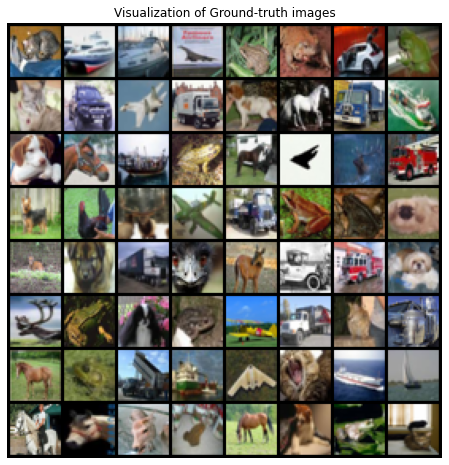

In [14]:
draw_sample_image(x[:batch_size//2], "Ground-truth images")

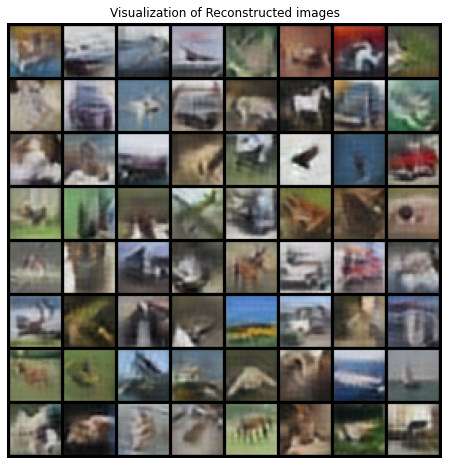

In [15]:
draw_sample_image(x_hat[:batch_size//2], "Reconstructed images")

### Step 6. Generate samples via random codes

In [16]:
def draw_random_sample_image(codebook, decoder, indices_shape):
    
    random_indices = torch.floor(torch.rand(indices_shape) * n_embeddings).long().to(DEVICE)
    codes = codebook.retrieve_random_codebook(random_indices)
    x_hat = decoder(codes.to(DEVICE))
    
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title("Visualization of Random Codes")
    plt.imshow(np.transpose(make_grid(x_hat.detach().cpu(), padding=2, normalize=True), (1, 2, 0)))

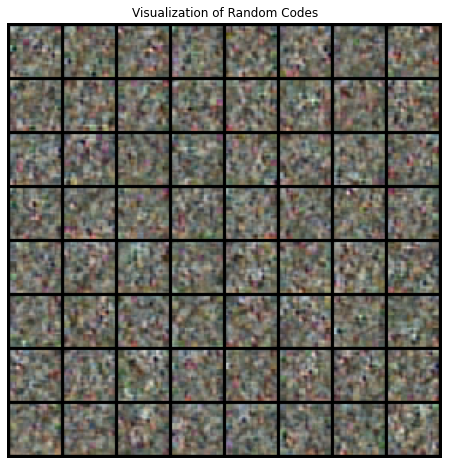

In [17]:
draw_random_sample_image(codebook, decoder, indices_shape=(batch_size//2, img_size[0]//4, img_size[1]//4))